In [52]:
import numpy as np
import qilisdk
import qutip as qt
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')

import hamiltonian
import dynamics
import plots
import estimator
import VQE

from qilisdk.backends import QutipBackend
from qilisdk.digital import Circuit, M, U1, CNOT, U2, U3, CZ, RX, RZ, H
from qilisdk.functionals.sampling import Sampling, SamplingResult
from qilisdk.functionals.time_evolution import TimeEvolution
from scipy.optimize import minimize

from qilisdk.analog import Schedule, X, Z, Y
from qilisdk.core import ket, tensor_prod
from qilisdk.backends import QutipBackend, CudaBackend
from qilisdk.functionals import TimeEvolution

In [53]:
nqubits = 2
min_w = -1.
max_w = 1.

H_true, true_weights = hamiltonian.create_random_hamiltonian(nqubits, min_w, max_w, backend='qutip')

psi_0 = dynamics.initialize_down_state(nqubits)



true_weights = [-0.66275718, -0.90763743,  0.14737293,  0.6965676,  -0.41580799]

#true_weights = [0.5, 0.8]
#true_weights = [0.5, 0.25, -0.8, 0.1, 0.32]
H_true = hamiltonian.create_hamiltonian_from_weights(nqubits, true_weights, backend='qutip')

print(H_true.H, "\n")

print("Weights:", true_weights)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.42813254 -0.90763743 -0.66275718  0.        ]
 [-0.90763743 -0.13338668  0.         -0.66275718]
 [-0.66275718  0.          0.96500266 -0.90763743]
 [ 0.         -0.66275718 -0.90763743 -1.25974852]] 

Weights: [-0.66275718, -0.90763743, 0.14737293, 0.6965676, -0.41580799]


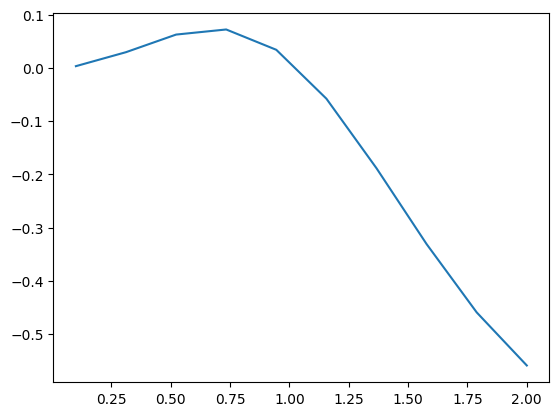

In [54]:
ti = 0
times = np.linspace(0.1, 2, 10)
nsteps = 100
nshots = 500

final_states = []
z_list_1 = []
x_list_1 = []
z_list_2 = []
x_list_2 = []
timestamp_measurements = []

for tf in times:
    sim = dynamics.time_evolution(H_true, psi_0, ti, tf, nsteps)
    observables = dynamics.calculate_expectation_values(sim, H_true)

    z_list_1.append(float(observables['Sz'][-1][0]))
    x_list_1.append(float(observables['Sx'][-1][0]))
    z_list_2.append(float(observables['Sz'][-1][1]))
    x_list_2.append(float(observables['Sx'][-1][1]))

    target_state = sim.states[-1]
    final_states.append(target_state)

    #sample from final state
    measurements_z = dynamics.sample_from_state(target_state, nqubits, nshots, basis='z')
    measurements_x = dynamics.sample_from_state(target_state, nqubits, nshots, basis='x')
    timestamp_measurements.append([measurements_z, measurements_x]) #timestamp_measurements[time][basis][shot]

plt.plot(times, x_list_1)

## Build ansatz Hamiltonian

In [55]:
def parameter_shift_grad(cost_fn, params, shift=0.05):
    grads = np.zeros_like(params)
    base_cost = cost_fn(params)  # Cache base cost
    
    for i in range(len(params)):
        e = np.zeros_like(params)
        e[i] = 1.0
        
        plus_cost = cost_fn(params + shift * e)
        minus_cost = cost_fn(params - shift * e)
        
        grads[i] = (plus_cost - minus_cost) / 2
        
        # Optional: gradient clipping
        if abs(grads[i]) > 100:  # Prevent exploding gradients
            grads[i] = np.sign(grads[i]) * 100
    
    # Normalize gradients (helps with ill-conditioned problems)
    grad_norm = np.linalg.norm(grads)
    if grad_norm > 0:
        grads = grads / grad_norm
        
    return grads

In [56]:
H_initial, initial_weights = hamiltonian.create_random_hamiltonian(nqubits, min_w, max_w, backend='qutip')


# H_initial = hamiltonian.create_hamiltonian_from_weights(nqubits, [0.45, 0.85], backend='qutip')
# initial_weights = [0.434, 0.859]

#initial_weights = [0.52, 0.24, -0.81, 0.13, 0.30]

# minimize with scipy 

# res = minimize(lambda p: VQE.nll_cost(p, nqubits, psi_0, ti, times, nsteps, timestamp_measurements),
#                initial_weights, method='COBYLA',
#                options={'maxiter': 100})


res = minimize(
    fun=lambda p: VQE.nll_cost(p, nqubits, psi_0, ti, times, nsteps, timestamp_measurements),
    x0=initial_weights,
    method='L-BFGS-B',
    jac=lambda p: parameter_shift_grad(
        lambda x: VQE.nll_cost(x, nqubits, psi_0, ti, times, nsteps, timestamp_measurements),
        p
    ),
    options={
        'maxiter': 2000,           # Increase iterations
        'ftol': 1e-10,            # Function tolerance
        'gtol': 1e-8,             # Gradient tolerance  
        'maxfun': 10000,          # Max function evaluations
        'disp': True              # Print convergence messages
    }
)


print("Optimization finished, success:", res.success, ", loss function:", res.fun)
print("best parameters:", res.x)
print(true_weights)

2.9659286829154126
2.9659286829154126
2.9685732023730265
2.9811515870021714


/var/folders/wh/28dwfv8x0qzfwl1_0pyzvs6h0000gp/T/ipykernel_43260/415809140.py:16: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(


3.0409088290071384
2.9134636080956375
2.9428875246073054
2.9944055205445457
2.9182127803723032
3.017290137127234
2.9349750516084203
3.0052097431575664
2.5100469905062903
2.5100469905062903
2.52721885994901
2.5037781581159178
2.5276664106495916
2.4991172574637166
2.520711694155238
2.506665885930441
2.5211071845819197
2.5042443106159458
2.542786349872204
2.4841535976867326
2.5483477518438713
2.5483477518438713
2.545442665663453
2.557992572294112
2.504368628520593
2.6053269530134147
2.5741149354928967
2.5322904254701455
2.5388191851311586
2.5647769468484283
2.540381392225556
2.564053960909647
2.4515363734733744
2.4515363734733744
2.4593855797399815
2.452919916205981
2.448445857172719
2.4637472017545665
2.4694009006102235
2.4420652087918473
2.45260700458805
2.4554590257841378
2.4673479809760206
2.4424444963573237
2.820446397839992
2.820446397839992
2.8103148851634083
2.839905020591171
2.8114884008405556
2.874779176460439
2.788474922453783
2.852236999589169
2.7753278806207393
2.852343897713

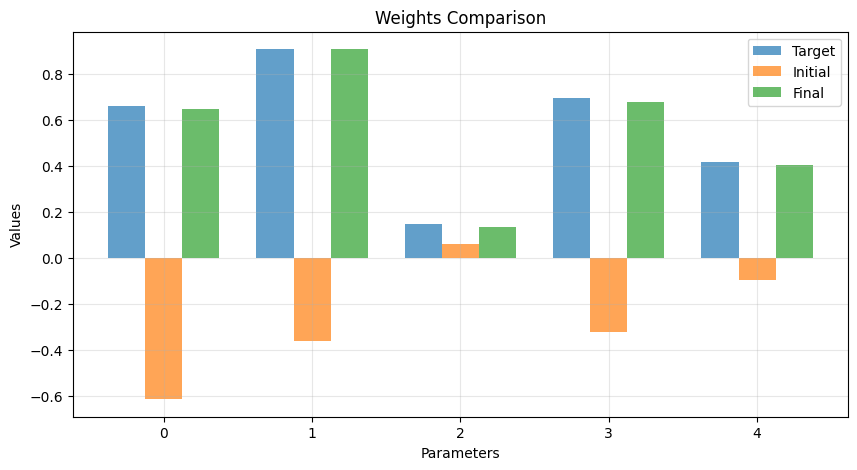

In [57]:
# Quick plot if you just want to see the comparison
def quick_plot_weights(target, initial, final):
    """Quick bar plot for weight comparison"""
    x = np.arange(len(target))
    width = 0.25
    
    plt.figure(figsize=(10, 5))
    plt.bar(x - width, target, width, label='Target', alpha=0.7)
    plt.bar(x, initial, width, label='Initial', alpha=0.7)
    plt.bar(x + width, final, width, label='Final', alpha=0.7)
    
    plt.xlabel('Parameters')
    plt.ylabel('Values')
    plt.title('Weights Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Usage:
abs_t = [abs(x) for x in true_weights]
abs_f = [abs(x) for x in res.x]
quick_plot_weights(abs_t, initial_weights, abs_f)

In [58]:
H_final = hamiltonian.create_hamiltonian_from_weights(nqubits, res.x, backend='qutip')

z_list_3, x_list_3, z_list_4, x_list_4 = [] , [], [] , []

for tf in times:
    sim = dynamics.time_evolution(H_final, psi_0, ti, tf, nsteps)
    observables = dynamics.calculate_expectation_values(sim, H_final)

    z_list_3.append(float(observables['Sz'][-1][0]))
    x_list_3.append(float(observables['Sx'][-1][0]))
    z_list_4.append(float(observables['Sz'][-1][1]))
    x_list_4.append(float(observables['Sx'][-1][1]))

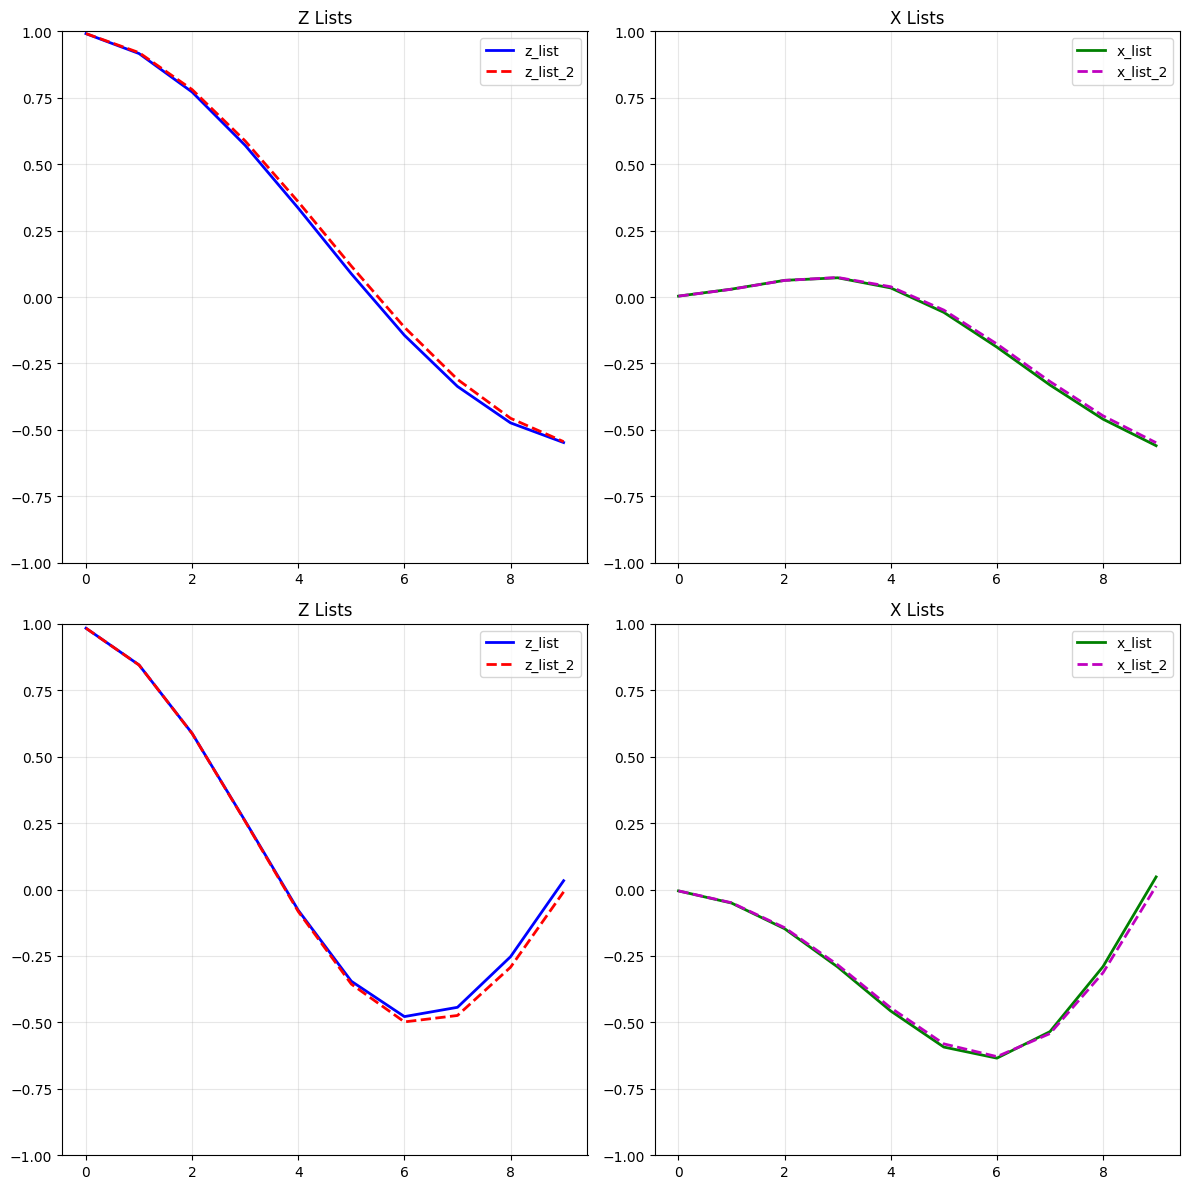

In [59]:
def plot_expectations(z_list, x_list, z_list_2, x_list_2, z_list_3, x_list_3, z_list_4, x_list_4):
    # Create side-by-side subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

    # Left plot: z lists
    ax1.plot(z_list, 'b-', label='z_list', linewidth=2)
    ax1.plot(z_list_3, 'r--', label='z_list_2', linewidth=2)
    ax1.set_title('Z Lists')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-1,1)
    # Right plot: x lists  
    ax2.plot(x_list, 'g-', label='x_list', linewidth=2)
    ax2.plot(x_list_3, 'm--', label='x_list_2', linewidth=2)
    ax2.set_title('X Lists')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-1,1)

    # Left plot: z lists
    ax3.plot(z_list_2, 'b-', label='z_list', linewidth=2)
    ax3.plot(z_list_4, 'r--', label='z_list_2', linewidth=2)
    ax3.set_title('Z Lists')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(-1,1)
    # Right plot: x lists  
    ax4.plot(x_list_2, 'g-', label='x_list', linewidth=2)
    ax4.plot(x_list_4, 'm--', label='x_list_2', linewidth=2)
    ax4.set_title('X Lists')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(-1,1)
    plt.tight_layout()
    plt.show()


plot_expectations(z_list_1, x_list_1, z_list_2, x_list_2, z_list_3, x_list_3, z_list_4, x_list_4)

In [60]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Experimental Hamiltonian Learning via Finite-Shot Pauli Measurements
====================================================================

This script implements *experimentally realistic* Hamiltonian learning
based on projective Pauli measurements simulated with finite statistics.


We consider a 1D spin-½ chain with translation-invariant, time-independent
Hamiltonian:

    H = sum_i ( Jx X_i X_{i+1} + Jy Y_i Y_{i+1} + Jz Z_i Z_{i+1} )
        + sum_i ( hx X_i + hy Y_i + hz Z_i )

and aim to learn the global couplings (Jx, Jy, Jz, hx, hy, hz)
from the time evolution of *experimentally accessible* local observables.

 
- Uses joint Pauli measurements to simulate realistic finite-shot experiments.
- Stores mean, standard deviation, and standard error of each observable.
- Trains an NN to infer global Hamiltonian parameters from these statistics.
- Produces diagnostics and visualization with error bars.
"""

# =============================================================================
# Imports
# =============================================================================
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.linalg import matrix_exp
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from numpy import kron

pt = torch

# =============================================================================
# Helper functions
# =============================================================================
def normalize(psi_np):
    return psi_np / np.sqrt(np.sum(np.abs(psi_np) ** 2))

def get_empty_matrix(D):
    return pt.zeros((D, D), dtype=pt.complex128)

id_local_np = np.array([[1., 0.], [0., 1.]], dtype=complex)
sigma_x_np  = np.array([[0., 1.], [1., 0.]], dtype=complex)
sigma_y_np  = 1j * np.array([[0., -1.], [1., 0]], dtype=complex)
sigma_z_np  = np.array([[1., 0.], [0., -1.]], dtype=complex)

def get_Identity(k):
    Id = id_local_np
    for _ in range(k - 1):
        Id = kron(Id, id_local_np)
    return Id

def get_spin_operator(A, L, i):
    if i == 1:
        Op = kron(A, get_Identity(L-1))
    elif i == L:
        Op = kron(get_Identity(L-1), A)
    else:
        Op = kron(get_Identity(i-1), kron(A, get_Identity(L-i)))
    return Op

def get_expectation_value(A, rho):
    return (pt.trace(A @ rho)).real

def get_rho(psi):
    return pt.outer(psi.conj(), psi)

def generate_spin_fock_basis(L):
    basis_size = 2 ** L
    return [tuple(int(bit) for bit in np.binary_repr(i, width=L)) for i in range(basis_size)]

def get_fidelity_torch(rho, sigma):
    rho_np, sigma_np = rho.detach().cpu().numpy(), sigma.detach().cpu().numpy()
    rho_sqrt = sqrtm(rho_np)
    tmp = sqrtm(rho_sqrt @ sigma_np @ rho_sqrt)
    return (np.trace(tmp) ** 2).real

# =============================================================================
# Sampling: joint Pauli measurement
# =============================================================================
def sample_joint_pauli_measurement(psi, paulis, qubits, N_shots=1000):
    """
    Simulate joint projective measurement of a Pauli string on given qubits.

    Args:
        psi (torch.Tensor): state vector |psi> 
        paulis (list[str]): e.g. ['X'], ['Z'], or ['X','Y']
        qubits (list[int]): indices in [1..L]
        N_shots (int): number of measurement shots

    Returns:
        mean, std, stderr of ±1 measurement outcomes
    """
    global L
    n = len(qubits)
    psi = psi.clone()

    # Apply basis rotations to bring measurement to Z basis
    U_total = np.eye(2 ** L, dtype=complex)
    for p, q in zip(paulis, qubits):
        if p == 'X':
            U_local = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)
        elif p == 'Y':
            U_local = np.array([[1, -1j], [1j, 1]], dtype=complex) / np.sqrt(2)
        elif p == 'Z':
            U_local = np.eye(2, dtype=complex)
        else:
            raise ValueError(f"Invalid Pauli {p}")

        # Embed U_local on qubit q
        U_emb = 1
        for i in range(1, L + 1):
            U_emb = kron(U_emb, U_local if i == q else np.eye(2))
        U_total = U_emb @ U_total

    # Rotate into measurement basis
    psi_rot = torch.tensor(U_total, dtype=torch.complex128) @ psi

    # Probability distribution (ensure normalization)
    probs = torch.abs(psi_rot) ** 2
    probs = probs.detach().cpu().numpy()
    probs = probs / probs.sum()  

    # Draw outcomes according to |ψ|²
    outcomes = np.random.choice(2 ** L, size=N_shots, p=probs)

    # Compute ±1 signs for given Pauli string
    signs = np.ones(N_shots)
    for idx, q in enumerate(qubits):
        bits = (outcomes >> (L - q)) & 1
        signs *= np.where(bits == 0, 1, -1)

    # Statistics
    mean = np.mean(signs)
    std = np.std(signs)
    stderr = std / np.sqrt(N_shots)
    return mean, std, stderr

def build_H_from_params(Jx, Jy, Jz, hx, hy, hz, PBC):
    H = get_empty_matrix(D)
    for i in range(1, L):
        H += Jx * X[i] @ X[i+1] + Jy * Y[i] @ Y[i+1] + Jz * Z[i] @ Z[i+1]
    if PBC == 1:
        H += Jx * X[L] @ X[1] + Jy * Y[L] @ Y[1] + Jz * Z[L] @ Z[1]
    for i in range(1, L+1):
        H += hx * X[i] + hy * Y[i] + hz * Z[i]
    return H

def prepare_initial_state(L, kind="basis_0", seed=None):
    """
    Prepare various initial pure states |ψ₀⟩ for a spin chain of length L.

    Parameters
    ----------
    L : int
        Number of spins (qubits).
    kind : str
        Type of initial state. Options:
            "basis_0"   : |000...0>
            "basis_1"   : |111...1>
            "plus"      : |+++...+>  (X eigenstate)
            "y_plus"    : |+i +i ... +i> (Y eigenstate)
            "neel"      : |0101...>  (alternating up/down)
            "ghz_z"     : (|000...0> + |111...1>)/√2   (Z-basis GHZ)
            "ghz_x"     : (|+++...+> + |---...->)/√2   (X-basis GHZ)
            "random"    : Haar-random normalized state (use seed)
    seed : int or None
        Random seed for reproducibility (used for "random" type).

    Returns
    -------
    psi_0 : torch.Tensor (complex128)
        Normalized pure state vector |ψ₀⟩ of size (2**L,).
    rho_0 : torch.Tensor (complex128)
        Corresponding density matrix ρ₀ = |ψ₀⟩⟨ψ₀|.
    """
    if seed is not None:
        np.random.seed(seed)

    D = 2 ** L
    psi = np.zeros(D, dtype=complex)

    # --- Computational basis states ---
    if kind == "basis_0":
        psi[0] = 1.0

    elif kind == "basis_1":
        psi[-1] = 1.0

    # --- Product states ---
    elif kind == "plus":
        psi[:] = 1.0 / np.sqrt(D)

    elif kind == "y_plus":
        # |+i> = (|0> + i|1>)/√2 per qubit
        psi[:] = 0
        for i in range(D):
            bits = np.array(list(np.binary_repr(i, width=L))).astype(int)
            phase = (1j) ** np.sum(bits)
            psi[i] = 1 / (2 ** (L / 2)) * phase

    elif kind == "neel":
        pattern = "".join(str(i % 2) for i in range(L))
        idx = int(pattern, 2)
        psi[idx] = 1.0

    # --- Entangled states ---
    elif kind == "ghz_z" or kind == "ghz":
        psi[0] = 1.0 / np.sqrt(2)
        psi[-1] = 1.0 / np.sqrt(2)

    elif kind == "ghz_x":
        # |GHZ_x> = (|+++...+> + |---...->)/√2
        plus_state = np.ones(D, dtype=complex) / np.sqrt(D)
        minus_state = np.zeros(D, dtype=complex)
        # Construct |---...-> = tensor of σ_z acting on |+++...+>
        for i in range(D):
            bits = np.array(list(np.binary_repr(i, width=L))).astype(int)
            parity = (-1) ** np.sum(bits)
            minus_state[i] = parity / np.sqrt(D)
        psi = (plus_state + minus_state) / np.sqrt(2)

    # --- Random state ---
    elif kind == "random":
        real = np.random.randn(D)
        imag = np.random.randn(D)
        psi = real + 1j * imag
        psi /= np.linalg.norm(psi)

    else:
        raise ValueError(f"Unknown state type: {kind}")

    psi_0 = pt.tensor(psi, dtype=pt.complex128)
    rho_0 = get_rho(psi_0)
    return psi_0, rho_0

# =============================================================================
# Visualize initial state's single-qubit Bloch vectors
# =============================================================================
import matplotlib.pyplot as plt

def plot_initial_bloch_vectors(psi_0, L, title=None):
    """
    Compute and visualize ⟨X_i⟩, ⟨Y_i⟩, ⟨Z_i⟩ for each qubit of the initial state.
    """
    rho_0 = get_rho(psi_0)
    X_vals, Y_vals, Z_vals = [], [], []

    for i in range(1, L + 1):
        X_vals.append(get_expectation_value(X[i], rho_0).item())
        Y_vals.append(get_expectation_value(Y[i], rho_0).item())
        Z_vals.append(get_expectation_value(Z[i], rho_0).item())

    qubits = np.arange(1, L + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(qubits, X_vals, "o-", color="red", label="⟨X⟩")
    plt.plot(qubits, Y_vals, "s-", color="green", label="⟨Y⟩")
    plt.plot(qubits, Z_vals, "d-", color="blue", label="⟨Z⟩")
    plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    plt.xlabel("qubit index i")
    plt.ylabel("expectation value")
    if title is None:
        title = "Initial-state local Bloch components"
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Optional: print numeric summary
    print("⟨X_i⟩ =", np.round(X_vals, 3))
    print("⟨Y_i⟩ =", np.round(Y_vals, 3))
    print("⟨Z_i⟩ =", np.round(Z_vals, 3))

# =============================================================================
# Visualize two-qubit correlators ⟨X_i X_j⟩, ⟨Y_i Y_j⟩, ⟨Z_i Z_j⟩
# =============================================================================

def plot_two_qubit_correlators(psi, L, title=None):
    """
    Compute and plot all two-qubit correlators ⟨σ^α_i σ^α_j⟩
    for α ∈ {X, Y, Z}, as L×L heatmaps.

    Parameters
    ----------
    psi : torch.Tensor (complex128)
        State vector |ψ⟩.
    L : int
        Number of qubits.
    title : str or None
        Optional plot title prefix.
    """
    rho = get_rho(psi)

    # Allocate correlation matrices
    Cx = np.zeros((L, L), dtype=float)
    Cy = np.zeros((L, L), dtype=float)
    Cz = np.zeros((L, L), dtype=float)

    for i in range(1, L + 1):
        for j in range(1, L + 1):
            Cx[i - 1, j - 1] = get_expectation_value(X[i] @ X[j], rho).item()
            Cy[i - 1, j - 1] = get_expectation_value(Y[i] @ Y[j], rho).item()
            Cz[i - 1, j - 1] = get_expectation_value(Z[i] @ Z[j], rho).item()

    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    pauli_labels = ["X", "Y", "Z"]
    correlators = [Cx, Cy, Cz]
    vmax = 1.0
    vmin = -1.0

    for ax, C, lab in zip(axs, correlators, pauli_labels):
        im = ax.imshow(C, vmin=vmin, vmax=vmax, cmap="coolwarm", origin="lower")
        ax.set_xticks(range(L))
        ax.set_yticks(range(L))
        ax.set_xlabel("site j")
        ax.set_ylabel("site i")
        ax.set_title(f"⟨{lab}_i {lab}_j⟩")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    if title is None:
        title = "Two-qubit correlators"
    fig.suptitle(title, fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

    # Optional: numerical summary
    print(f"\n⟨X_i X_j⟩ matrix:\n{np.round(Cx, 2)}")
    print(f"\n⟨Y_i Y_j⟩ matrix:\n{np.round(Cy, 2)}")
    print(f"\n⟨Z_i Z_j⟩ matrix:\n{np.round(Cz, 2)}")

# =============================================================================
# Visualize two-qubit correlators and connected correlations
# ==================...

ModuleNotFoundError: No module named 'pandas'